### Libraries & API Setup

In [80]:
# Common libraries
import matplotlib.pyplot as plt
from datetime import datetime
import requests
import json 
import pandas as pd
from utils import returns_df, plot_sector_performance

# API setup
from messari.messari import Messari                   # Messari
#m = Messari('cb0d3a33-c4c5-4b50-9fff-5dce65d44b97')   # Messari
m = Messari('f8783744-faf2-475e-8675-b3769cd55c81')   # Messari
from pycoingecko import CoinGeckoAPI                  # Coingecko
cg = CoinGeckoAPI()                                   # Coingecko
API_KEY = '27mKdxqslM3aORzuco6LoqzKjFc'               # Glassnode

### Import Data

In [81]:
start = '2022-01-01'
end = '2022-03-31'
sector = ('UNI', 'CRV', 'LRC', 'SUSHI')

In [82]:
cdata = pd.DataFrame(cg.get_coins_markets('usd'))

In [83]:
mdata = m.get_all_assets(asset_fields=['metrics'], to_dataframe=True)
prices = m.get_metric_timeseries(list(sector), 'price', start, end)
asset_returns = returns_df(prices)

In [84]:
ldata = pd.DataFrame(requests.get('https://api.llama.fi/protocols').json())

### Coarse Merge

In [6]:
cdata['symbol'].str.lower()
master = cdata.merge(ldata, how = 'left', left_on = 'symbol', right_on = 'symbol')

In [7]:
master = master.merge(mdata, how = 'left', left_on = 'id_x', right_on = 'slug')

In [ ]:
master.head()

### METRICS

### Price Action 

In [78]:
idx = pd.IndexSlice
sector_prices = prices.loc[:, idx[sector, 'close']].droplevel(1, axis = 1).head()

<AxesSubplot:xlabel='timestamp'>

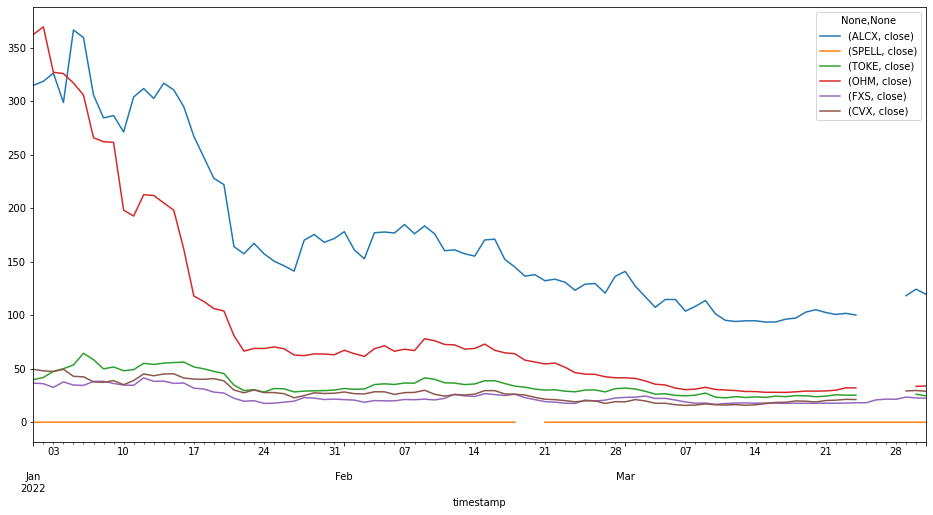

In [75]:
sector_prices.plot(figsize=(16, 8))

### Returns

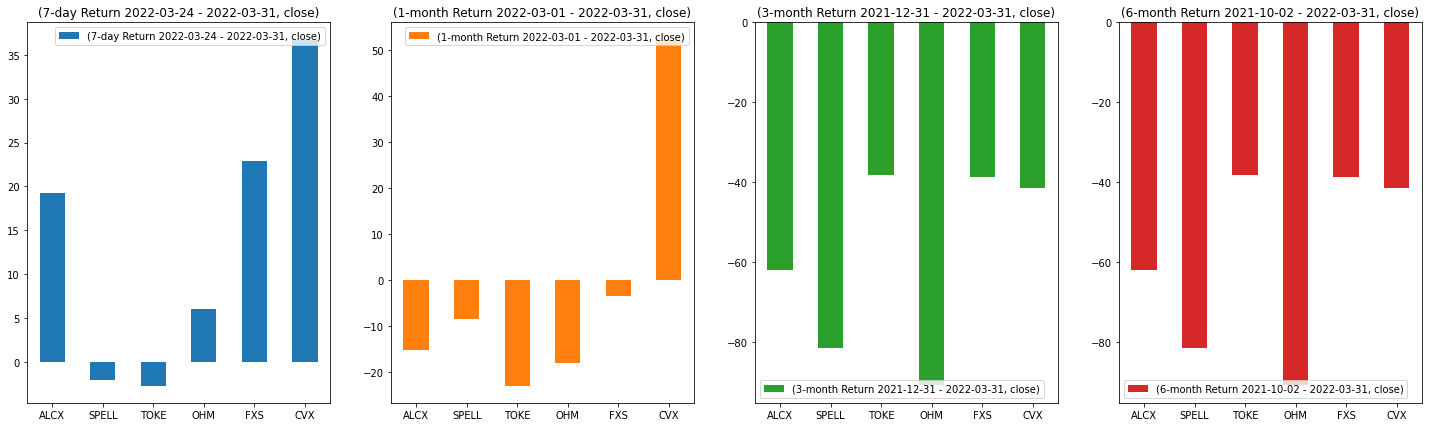

In [68]:
idx = pd.IndexSlice
sector_returns = asset_returns.loc[idx[sector, 'close'], :]
ax = sector_returns.unstack(level=1).plot(kind='bar', subplots=True, rot=0, figsize=(25, 7), layout=(1, 4))